# Mitigation

In [11]:
import collections
import math
import numpy as np
import pandas as pd
import scipy
from scipy.special import perm # for nPk 
from sympy.functions.combinatorial.numbers import stirling
import matplotlib.pyplot as plt 
pd.set_option('precision', 10)
%matplotlib inline

## IDEAL BAYES

In [3]:
def uni_ore_bayes(n, k):
    outputs = 0
    for c in range(n):
        if k < c+1:
            break
        outputs = outputs + (stirling(n, c+1) * math.factorial(c+1))
    inputs = pow(k, n)
    return outputs / inputs

## IDEAL BUCKET

In [4]:
def trailing_zero(n):
    x = int(bin(n)[2:])
    count = 0
    while ((x & 1 ) == 0):
        x = x >> 1
        count += 1
    return count

def report_number(K, I):
    r = [[0]* (I + 1) for _ in range(K+1)]
    r[1][1] = 1
    for k in range(2, K+1):
        b = trailing_zero(k-1)
        for i in range(1, I+1):
            r[k][i] = r[k-1][i] + r[k-1][i-1] - r[k-1- int(math.pow(2,b))][i-1]
    return r

In [5]:
def c_bell(i, n):
    c = 0
    for u in range(0, i+1):
        c = c + pow(-1, (i-u)) * scipy.special.comb(i, u, exact = True) * pow(u, n)
    return c

def m_bell(i, n):
    return stirling(n, i) * math.factorial(i)

In [12]:
def g4(i, b, s):
    f = math.floor(i/b)
    m = i % b
    left = pow( (scipy.special.comb(s, f+1, exact = True)) , m)
    right = pow( (scipy.special.comb(s, f, exact = True)) , (b-m))
    return left * right

def cat4(n, k, b):
    prior = pow(k, -n)
    v = 0
    for i in range(1,min(n, k)+1):
        v = v + m_bell(i, n) * g4(i, b, k/b)
    return v * prior

def big_cat4(n, k, b): # logs to avoid overflow. Cat's ordered bell since s2 hits max recurrsion depth n = 1k
    prior = pow(k, n) # k, -n
    v = 0
    for i in range(1,min(n, k)+1):
        v = v + c_bell(i, n) * g4(i, b, k/b)
    v_log = math.log2(v)
    prior_log = math.log2(prior)
    r_log = v_log - prior_log
    r = pow(2, r_log)
    return r

### General Graph Code

In [7]:
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
font_choice = 14
plt.rcParams.update(plt.rcParamsDefault)
rc_fonts = {
    "text.usetex": True,
    "font.size": font_choice,
    'mathtext.default': 'regular',
    'axes.titlesize': font_choice,
    "axes.labelsize": font_choice,
    "legend.fontsize": font_choice,
    "xtick.labelsize": font_choice,
    "ytick.labelsize": font_choice,
    'figure.titlesize': font_choice,
    'figure.figsize': (8,5.25),
    'text.latex.preamble': [r'\usepackage{amsmath,nicefrac, sansmath}', 
                            r'\sansmath'],
    "font.family": "sans-serif",#"font.sans-serif": "computer modern",
    }
mpl.rcParams.update(rc_fonts)

#### Function of n, mitigation df

In [8]:
def df_mit(n_range, k, b): 
    kb = k * pow(2, b)
    n = 0
    n_list = []
    postIdeal_list = []
    mitIdeal_list = []
    for x in range(n_range):
        n = n + 1
        n_list.append(n)
        ideal = uni_ore_bayes(n, k)
        postIdeal_list.append(ideal)
        mit = big_cat4(n, kb, k) # b = k = 8
        mitIdeal_list.append(mit)
    df = pd.DataFrame(
        {'n':n_list,
         'postIdeal':postIdeal_list,
         'mitIdeal':mitIdeal_list
        }
    )
    return df

#### Funct of n, mitigation graph code

In [44]:
def graph_it_mit(n_range, k, df):
    ax = plt.figure().gca()
    plt.plot('n', 'postIdeal',
             color='red',
             data=df,
             linestyle='dotted',
             marker='', 
             label="Unmitigated")
    plt.plot('n', 'mitIdeal',
             color='green',
             data=df,
             linestyle='dashed',
             marker='', 
             label="Mitigated")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('n')
    plt.xlim(left = 0, right = n_range+1)
    plt.ylabel('Bayes vulnerability')
    plt.ylim(bottom=-.1, top = 1.1)
    
    plt.title('Effect of Mitigation on Ideal ORE Bayes vulnerability')
    plt.legend(loc='upper left')
    plt.savefig('mitigation_mit.png')
    plt.show()
    plt.close()

In [13]:
n_range = 100
k = 8
b = 3
df_m = df_mit(n_range, k, b)

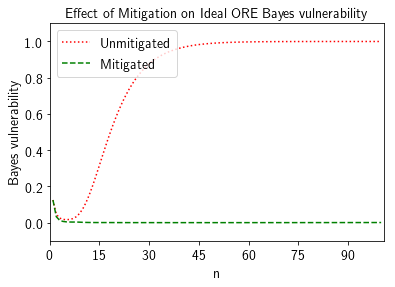

In [45]:
graph_it_mit(n_range, k, df_m)

In [40]:
df_m.iloc[51]

n                                                           52
postIdeal    9072761889350821313518514321330317940661472279...
mitIdeal                                       0.0002441711763
Name: 51, dtype: object